# Backpropagation Through Time




So far we repeatedly alluded to things like *exploding gradients*,
*vanishing gradients*, *truncating backprop*, and the need to
*detach the computational graph*. For instance, in the previous
section we invoked `s.detach()` on the sequence. None of this was really fully
explained, in the interest of being able to build a model quickly and
to see how it works. In this section we will delve a bit more deeply
into the details of backpropagation for sequence models and why (and
how) the math works. For a more detailed discussion, e.g. about
randomization and backprop also see the paper by
[Tallec and Ollivier, 2017](https://arxiv.org/abs/1705.08209).

We encountered some of the effects of gradient explosion when we first
implemented recurrent neural networks . In
particular, if you solved the problems in the problem set, you would
have seen that gradient clipping is vital to ensure proper
convergence. To provide a better understanding of this issue, this
section will review how gradients are computed for sequences. Note
that there is nothing conceptually new in how it works. After all, we are still merely applying the chain rule to compute gradients. Nonetheless it is
worth while reviewing backpropagation  for
another time.

Forward propagation in a recurrent neural network is relatively
straightforward. Back-propagation through time is actually a specific
application of back propagation in recurrent neural networks. It
requires us to expand the recurrent neural network one time step at a time to
obtain the dependencies between model variables and parameters. Then,
based on the chain rule, we apply back propagation to compute and
store gradients. Since sequences can be rather long this means that the dependency can be rather lengthy. E.g. for a sequence of 1000 characters the first symbol could potentially have significant influence on the symbol at position 1000. This is not really computationally feasible (it takes too long and requires too much memory) and it requires over 1000 matrix-vector products before we would arrive at that very elusive gradient. This is a process fraught with computational and statistical uncertainty. In the following we will address what happens and how to address this in practice.

## A Simplified Recurrent Network

We start with a simplified model of how an RNN works. This model ignores details about the specifics of the hidden state and how it is being updated. These details are immaterial to the analysis and would only serve to clutter the notation and make it look more intimidating.

$$h_t = f(x_t, h_{t-1}, w) \text{ and } o_t = g(h_t, w)$$

Here $h_t$ denotes the hidden state, $x_t$ the input and $o_t$ the output. We have a chain of values $\{\ldots (h_{t-1}, x_{t-1}, o_{t-1}), (h_{t}, x_{t}, o_t), \ldots\}$ that depend on each other via recursive computation. The forward pass is fairly straightforward. All we need is to loop through the $(x_t, h_t, o_t)$ triples one step at a time. This is then evaluated by an objective function measuring the discrepancy between outputs $o_t$ and some desired target $y_t$

$$L(x,y, w) = \sum_{t=1}^T l(y_t, o_t).$$

For backpropagation matters are a bit more tricky. Let's compute the gradients with regard to the parameters $w$ of the objective function $L$. We get that

$$\begin{aligned}
\partial_{w} L & = \sum_{t=1}^T \partial_w l(y_t, o_t) \\
	& = \sum_{t=1}^T \partial_{o_t} l(y_t, o_t) \left[\partial_w g(h_t, w) + \partial_{h_t} g(h_t,w) \partial_w h_t\right]
\end{aligned}$$

The first part of the derivative is easy to compute (this is after all the instantaneous loss gradient at time $t$). The second part is where things get tricky, since we need to compute the effect of the parameters on $h_t$. For each term we have the recursion:

$$\begin{aligned}
	\partial_w h_t & = \partial_w f(x_t, h_{t-1}, w) + \partial_h f(x_t, h_{t-1}, w) \partial_w h_{t-1} \\
	& = \sum_{i=t}^1 \left[\prod_{j=t}^i \partial_h f(x_j, h_{j-1}, w) \right] \partial_w f(x_{i}, h_{i-1}, w)
\end{aligned}$$

This chain can get *very* long whenever $t$ is large. While we can use the chain rule to compute $\partial_w h_t$ recursively, this might not be ideal. Let's discuss a number of strategies for dealing with this problem:

**Compute the full sum.** This is very slow and gradients can blow up,
since subtle changes in the initial conditions can potentially affect
the outcome a lot. That is, we could see things similar to the
butterfly effect where minimal changes in the initial conditions lead to disproportionate changes in the outcome. This is actually quite undesirable in terms of the model that we want to estimate. After all, we are looking for robust estimators that generalize well. Hence this strategy is almost never used in practice.

**Truncate the sum after $\tau$ steps.** This is what we've been
discussing so far. This leads to an *approximation* of the true
gradient, simply by terminating the sum above at $\partial_w
h_{t-\tau}$. The approximation error is thus given by $\partial_h
f(x_t, h_{t-1}, w) \partial_w h_{t-1}$ (multiplied by a product of
gradients involving $\partial_h f$). In practice this works quite
well. It is what is commonly referred to as truncated BPTT
(backpropgation through time). One of the consequences of this is that
the model focuses primarily on short-term influence rather than
long-term consequences. This is actually *desirable*, since it biases
the estimate towards simpler and more stable models.

**Randomized Truncation.** Lastly we can replace $\partial_w h_t$ by a
random variable which is correct in expectation but which truncates
the sequence. This is achieved by using a sequence of $\xi_t$ where
$\mathbf{E}[\xi_t] = 1$ and $\Pr(\xi_t = 0) = 1-\pi$ and furthermore
$\Pr(\xi_t = \pi^{-1}) = \pi$. We use this to replace the gradient:

$$z_t  = \partial_w f(x_t, h_{t-1}, w) + \xi_t \partial_h f(x_t, h_{t-1}, w) \partial_w h_{t-1}$$

It follows from the definition of $\xi_t$ that $\mathbf{E}[z_t] = \partial_w h_t$. Whenever $\xi_t = 0$ the expansion terminates at that point. This leads to a weighted sum of sequences of varying lengths where long sequences are rare but appropriately overweighted. [Tallec and Ollivier, 2017](https://arxiv.org/abs/1705.08209) proposed this in their paper. Unfortunately, while appealing in theory, the model does not work much better than simple truncation, most likely due to a number of factors. Firstly, the effect of an observation after a number of backpropagation steps into the past is quite sufficient to capture dependencies in practice. Secondly, the increased variance counteracts the fact that the gradient is more accurate. Thirdly, we actually *want* models that have only a short range of interaction. Hence BPTT has a slight regularizing effect which can be desirable.

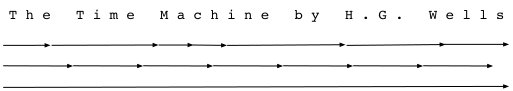

In [1]:
from IPython.display import SVG
SVG('../img/truncated-bptt.svg')



Fig.10.7.1: From top to bottom: randomized BPTT, regularly truncated BPTT and full BPTT

The picture above illustrates the three cases when analyzing the first few words of *The Time Machine*: randomized truncation partitions the text into segments of varying length. Regular truncated BPTT breaks it into sequences of the same length, and full BPTT leads to a computationally infeasible expression.

## The Computational Graph

In order to visualize the dependencies between model variables and parameters during computation in a recurrent neural network, we can draw a computational graph for the model, as shown below. For example, the computation of the hidden states of time step 3 $\mathbf{h}_3$ depends on the model parameters $\mathbf{W}_{hx}$ and $\mathbf{W}_{hh}$, the hidden state of the last time step $\mathbf{h}_2$, and the input of the current time step $\mathbf{x}_3$.

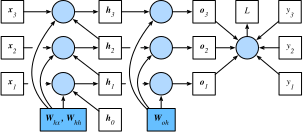

In [2]:
SVG('../img/rnn-bptt.svg')



Fig.10.7.2: Computational dependencies for a recurrent neural network model with three time steps. Boxes represent variables (not shaded) or parameters (shaded) and circles represent operators. 

## BPTT in Detail

Now that we discussed the general principle let's discuss BPTT in detail, distinguishing between different sets of weight matrices ($\mathbf{W}_{hx}, \mathbf{W}_{hh}$ and $\mathbf{W}_{oh}$) in a simple linear latent variable model:

$$\mathbf{h}_t = \mathbf{W}_{hx} \mathbf{x}_t + \mathbf{W}_{hh} \mathbf{h}_{t-1} \text{ and }
\mathbf{o}_t = \mathbf{W}_{oh} \mathbf{h}_t$$

Following the discussion in `chapter_backprop` we compute gradients $\partial L/\partial \mathbf{W}_{hx}$, $\partial L/\partial \mathbf{W}_{hh}$, and $\partial L/\partial \mathbf{W}_{oh}$ for
$L(\mathbf{x}, \mathbf{y}, \mathbf{W}) = \sum_{t=1}^T l(\mathbf{o}_t, y_t)$.
Taking the derivatives with respect to $W_{oh}$ is fairly straightforward and we obtain

$$\partial_{\mathbf{W}_{oh}} L = \sum_{t=1}^T \mathrm{prod}
\left(\partial_{\mathbf{o}_t} l(\mathbf{o}_t, y_t), \mathbf{h}_t\right)$$

The dependency on $\mathbf{W}_{hx}$ and $\mathbf{W}_{hh}$ is a bit more tricky since it involves a chain of derivatives. We begin with

$$\begin{aligned}
\partial_{\mathbf{W}_{hh}} L & = \sum_{t=1}^T \mathrm{prod}
\left(\partial_{\mathbf{o}_t} l(\mathbf{o}_t, y_t), \mathbf{W}_{oh}, \partial_{\mathbf{W}_{hh}} \mathbf{h}_t\right) \\
\partial_{\mathbf{W}_{hx}} L & = \sum_{t=1}^T \mathrm{prod}
\left(\partial_{\mathbf{o}_t} l(\mathbf{o}_t, y_t), \mathbf{W}_{oh}, \partial_{\mathbf{W}_{hx}} \mathbf{h}_t\right)
\end{aligned}$$

After all, hidden states depend on each other and on past inputs. The key quantity is how past hidden states affect future hidden states.

$$\partial_{\mathbf{h}_t} \mathbf{h}_{t+1} = \mathbf{W}_{hh}^\top
\text{ and thus }
\partial_{\mathbf{h}_t} \mathbf{h}_T = \left(\mathbf{W}_{hh}^\top\right)^{T-t}$$

Chaining terms together yields

$$\begin{aligned}
\partial_{\mathbf{W}_{hh}} \mathbf{h}_t & = \sum_{j=1}^t \left(\mathbf{W}_{hh}^\top\right)^{t-j} \mathbf{h}_j \\
\partial_{\mathbf{W}_{hx}} \mathbf{h}_t & = \sum_{j=1}^t \left(\mathbf{W}_{hh}^\top\right)^{t-j} \mathbf{x}_j.
\end{aligned}$$

A number of things follow from this potentially very intimidating expression. Firstly, it pays to store intermediate results, i.e. powers of $\mathbf{W}_{hh}$ as we work our way through the terms of the loss function $L$. Secondly, this simple *linear* example already exhibits some key problems of long sequence models: it involves potentially very large powers $\mathbf{W}_{hh}^j$. In it, eigenvalues smaller than $1$ vanish for large $j$ and eigenvalues larger than $1$ diverge. This is numerically unstable and gives undue importance to potentially irrelvant past detail. One way to address this is to truncate the sum at a computationally convenient size. Later on in this chapter we will see how more sophisticated sequence models such as LSTMs can alleviate this further. In code, this truncation is effected by *detaching* the gradient after a given number of steps.

## Summary

* Back-propagation through time is merely an application of backprop to sequence models with a hidden state.
* Truncation is needed for computational convencient and numerical stability.
* High powers of matrices can lead top divergent and vanishing eigenvalues. This manifests itself in the form of exploding or vanishing gradients.
* For efficient computation intermediate values are cached.

## Exercises

1. Assume that we have a symmetric matrix $\mathbf{M} \in \mathbb{R}^{n \times n}$ with eigenvalues $\lambda_i$. Without loss of generality assume that they are ordered in ascending order $\lambda_i \leq \lambda_{i+1}$. Show that $\mathbf{M}^k$ has eigenvalues $\lambda_i^k$.
1. Prove that for a random vector $\mathbf{x} \in \mathbb{R}^n$ with high probability $\mathbf{M}^k \mathbf{x}$ will by very much aligned with the largest eigenvector $\mathbf{v}_n$ of $\mathbf{M}$. Formalize this statement.
1. What does the above result mean for gradients in a recurrent neural network?
1. Besides gradient clipping, can you think of any other methods to cope with gradient explosion in recurrent neural networks?

